In [166]:
import sys
sys.path.append('../..')

import numpy as np
import pandas as pd
import copy
from matplotlib import pyplot as plt
from matplotlib import rc, cm, rcParams
rc('text', usetex=True)
rc('font', family='serif')
rcParams.update({'font.size': 18})

from scipy.stats import linregress
from scipy.optimize import lsq_linear, curve_fit

#import pickle

from analosis.utilities.useful_functions import Utilities, estimate_quality

In [2]:
path = '/Users/pierrefleury/GitHub/analosis/analosis/results'
input_kwargs = pd.read_csv(path + '/datasets/' + 'golden_sample_input_kwargs.csv')

In [3]:
# Estimate quality of golden sample images from SNR
quality = estimate_quality(input_kwargs, snr_cut=5)

In [75]:
# Import summary results for golden sample

path_summary = '/Users/pierrefleury/GitHub/analosis/analosis/results/summary/'
job = 'pm'
summary_g1_kwargs = pd.read_csv(path_summary + 'summary_gamma1_'+job+'.csv')
summary_g2_kwargs = pd.read_csv(path_summary + 'summary_gamma2_'+job+'.csv')

in_gamma1_converged = summary_g1_kwargs['in_gamma1'].to_numpy()
out_gamma1          = summary_g1_kwargs['out_gamma1'].to_numpy()
g1_lower_error      = summary_g1_kwargs['g1_lower'].to_numpy()
g1_upper_error      = summary_g1_kwargs['g1_upper'].to_numpy()
b_g1                = summary_g1_kwargs['b'].to_numpy()

in_gamma2_converged = summary_g2_kwargs['in_gamma2'].to_numpy()
out_gamma2          = summary_g2_kwargs['out_gamma2'].to_numpy()
g2_lower_error      = summary_g2_kwargs['g2_lower'].to_numpy()
g2_upper_error      = summary_g2_kwargs['g2_upper'].to_numpy()
b_g2                = summary_g2_kwargs['b'].to_numpy()

In [76]:
# Keep only the images where both components are converged
all_indices = np.arange(64)

converged_g1 = [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18,
                20, 21, 22, 23, 25, 26, 29, 30, 31, 32, 33, 34, 35, 36,
                37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 51, 53,
                54, 55, 56, 57, 58, 59, 60, 61, 62, 63]

converged_g2 = [0, 1, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                18, 19, 20, 21, 22, 24, 25, 26, 28, 29, 30, 31, 33, 34,
                35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 48, 53, 55,
                56, 57, 58, 59, 60, 61, 62, 63]

quality = [q for i, q in enumerate(quality) if i in converged_g1 and i in converged_g2]

for i in all_indices:
    if i not in converged_g1:
        in_gamma1_converged = np.insert(in_gamma1_converged, i, None)
        out_gamma1          = np.insert(out_gamma1, i, None)
        g1_lower_error      = np.insert(g1_lower_error, i, None)
        g1_upper_error      = np.insert(g1_upper_error, i, None)
        b_g1                = np.insert(b_g1, i, None)
    elif i not in converged_g2:
        in_gamma1_converged[i] = None
        out_gamma1[i]          = None
        g1_lower_error[i]      = None
        g1_upper_error[i]      = None
        b_g1[i]                = None
        
in_gamma1_converged = np.array([elt for elt in in_gamma1_converged if not np.isnan(elt)])
out_gamma1          = np.array([elt for elt in out_gamma1 if not np.isnan(elt)])
g1_lower_error      = np.array([elt for elt in g1_lower_error if not np.isnan(elt)])
g1_upper_error      = np.array([elt for elt in g1_upper_error if not np.isnan(elt)])
b_g1                = np.array([elt for elt in b_g1 if not np.isnan(elt)])

for i in all_indices:
    if i not in converged_g2:
        in_gamma2_converged = np.insert(in_gamma2_converged, i, None)
        out_gamma2          = np.insert(out_gamma2, i, None)
        g2_lower_error      = np.insert(g2_lower_error, i, None)
        g2_upper_error      = np.insert(g2_upper_error, i, None)
        b_g2                = np.insert(b_g2, i, None)
    elif i not in converged_g1:
        in_gamma2_converged[i] = None
        out_gamma2[i]          = None
        g2_lower_error[i]      = None
        g2_upper_error[i]      = None
        b_g2[i]                = None
        
in_gamma2_converged = np.array([elt for elt in in_gamma2_converged if not np.isnan(elt)])
out_gamma2          = np.array([elt for elt in out_gamma2 if not np.isnan(elt)])
g2_lower_error      = np.array([elt for elt in g2_lower_error if not np.isnan(elt)])
g2_upper_error      = np.array([elt for elt in g2_upper_error if not np.isnan(elt)])
b_g2                = np.array([elt for elt in b_g2 if not np.isnan(elt)])

In [81]:
# complete error bars
uncertainty_g1 = g1_lower_error + g1_upper_error
uncertainty_g2 = g2_lower_error + g2_upper_error

# difference with true value
error_g1 = abs(in_gamma1_converged - out_gamma1)
error_g2 = abs(in_gamma2_converged - out_gamma2)

In [90]:
quality = np.array(quality)
Q = np.log10(quality/1000)

[0.90976619]


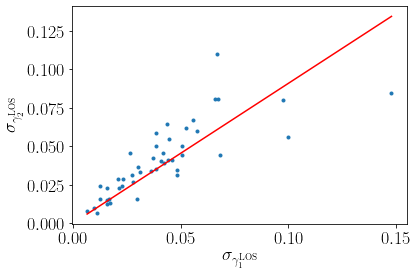

In [172]:
# check that error bars are well correlated
f = lambda x, a: a * x
popt, pcov = curve_fit(f, uncertainty_g1, uncertainty_g2)
print(popt)
mn = np.min(uncertainty_g1)
mx = np.max(uncertainty_g1)
g1 = np.linspace(mn, mx, 2)
g2 = f(g1, *popt)
plt.plot(uncertainty_g1, uncertainty_g2, '.')
plt.plot(g1, g2, '-r')
plt.xlabel(r'$\sigma_{\gamma^{\rm LOS}_1}$')
plt.ylabel(r'$\sigma_{\gamma^{\rm LOS}_2}$')
plt.savefig('correlated_uncertainties.pdf', bbox_inches='tight')
plt.show()

[0.639558]


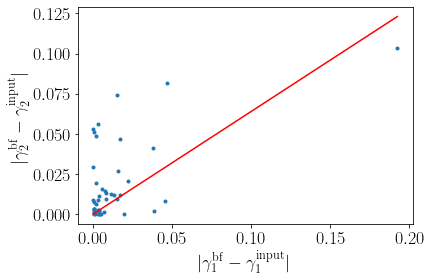

In [173]:
# check that errors are correlated
f = lambda x, a: a * x
popt, pcov = curve_fit(f, error_g1, error_g2)
print(popt)
mn = np.min(error_g1)
mx = np.max(error_g1)
delta1 = np.linspace(mn, mx, 2)
delta2 = f(delta1, *popt)
plt.plot(error_g1, error_g2, '.')
plt.plot(delta1, delta2, '-r')
plt.xlabel(r'$|\gamma_1^{\rm bf}-\gamma_1^{\rm input}|$')
plt.ylabel(r'$|\gamma_2^{\rm bf}-\gamma_2^{\rm input}|$')
plt.savefig('correlated_errors.pdf', bbox_inches='tight')
plt.show()

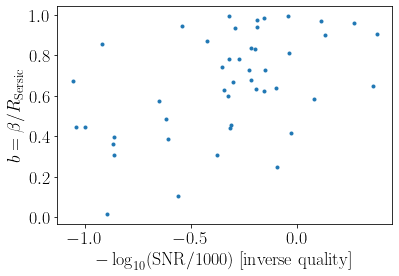

In [147]:
# compare our two measures of quality
plt.plot(-Q, b_g1, '.')
plt.xlabel(r'$-\log_{10}(\mathrm{SNR}/1000)$ [inverse quality]')
plt.ylabel(r'$b=\beta/R_{\rm Sersic}$')
plt.savefig('compare_b_SNR.pdf', bbox_inches='tight')
plt.show()

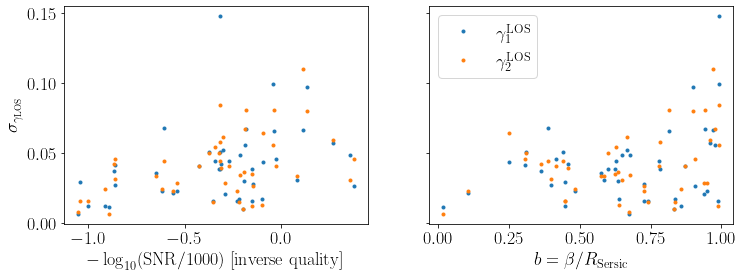

In [145]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,4))
fig.subplots_adjust(hspace=0)

ax1.plot(-Q, uncertainty_g1, '.')
ax1.plot(-Q, uncertainty_g2, '.')
ax1.set_ylabel(r'$\sigma_{\gamma_{\rm LOS}}$')
ax1.set_xlabel(r'$-\log_{10}(\mathrm{SNR}/1000)$ [inverse quality]')
#ax1.legend([r'$\gamma_1^{\rm LOS}$', r'$\gamma_2^{\rm LOS}$'])

ax2.plot(b_g1, uncertainty_g1, '.')
ax2.plot(b_g1, uncertainty_g2, '.')
ax2.set_xlabel(r'$b=\beta/R_{\rm Sersic}$')
ax2.legend([r'$\gamma_1^{\rm LOS}$', r'$\gamma_2^{\rm LOS}$'])

plt.savefig('sigma_SNR_b.pdf', bbox_inches='tight')
plt.show()

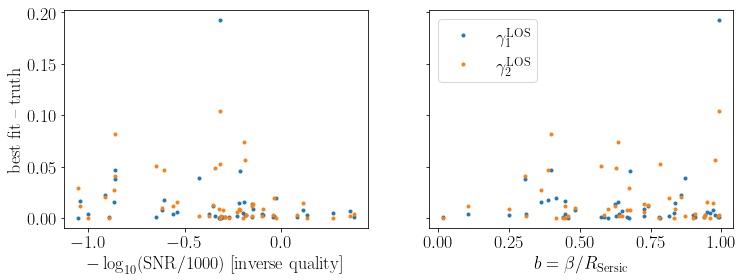

In [146]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,4))
fig.subplots_adjust(hspace=0)

ax1.plot(-Q, error_g1, '.')
ax1.plot(-Q, error_g2, '.')
ax1.set_ylabel(r'best fit -- truth')
ax1.set_xlabel(r'$-\log_{10}(\mathrm{SNR}/1000)$ [inverse quality]')
#ax1.legend([r'$\gamma_1^{\rm LOS}$', r'$\gamma_2^{\rm LOS}$'])

ax2.plot(b_g1, error_g1, '.')
ax2.plot(b_g1, error_g2, '.')
ax2.set_xlabel(r'$b=\beta/R_{\rm Sersic}$')
ax2.legend([r'$\gamma_1^{\rm LOS}$', r'$\gamma_2^{\rm LOS}$'])

plt.savefig('error_SNR_b.pdf', bbox_inches='tight')
plt.show()